In [101]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline  
from scipy import stats

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 영어 dataset에서 title만 추출해서 자연어처리를 위한 전처리를 하자

In [65]:
#데이터 불러오기
us_videos = pd.read_csv(r'C:\Users\injoo\광주 인공지능 사관학교\로테이션\자연어처리&추천시스템 김준태\미니프로젝트 데이터\USvideos.csv', error_bad_lines=False)


b'Skipping line 2401: expected 11 fields, saw 21\nSkipping line 2800: expected 11 fields, saw 21\nSkipping line 5297: expected 11 fields, saw 12\nSkipping line 5299: expected 11 fields, saw 12\nSkipping line 5300: expected 11 fields, saw 12\nSkipping line 5301: expected 11 fields, saw 12\n'


### 이전과 마찬가지로 중복되는 동영상들은 제거해주자

In [66]:
# 우선 float64인 date의 datatype을 바꿔주자
us_videos['date'] = us_videos['date'].apply(lambda x: str(x).replace(".", "-"))
us_videos['date'] = us_videos['date'].apply(lambda x: '2017-'+str(x))
us_videos['date'] = pd.to_datetime(us_videos['date'], format='%Y-%d-%m')
result = us_videos.drop_duplicates('video_id', keep='last').values
duplicates_removed = pd.DataFrame(result, columns = us_videos.columns)

In [67]:
only_title = duplicates_removed['title']

In [68]:
title_data = only_title

## Title만 가진 데이터를 추출했으니 전처리를 해주자

In [69]:
#단어 아니면 삭제
title_data = title_data.str.replace("[^\w]", " ")
#혹시나 공백이 있으면
title_data= title_data.replace('', np.nan)

#결측치 있으면 모두 제거
title_data = title_data.dropna(how='any')

In [86]:
titles_list = []
#숫자 제거가 덜 되었다. 하나하나 돌면서 숫자도 제거해주자. 단 단어랑 붙어 있는 숫자는 살려주자
for title in title_data:
    title = title.split(" ")
    word_without_number = []
    for word in title:
        output = re.sub(r'\d+', '', word)
        if output != '':
            word_without_number.append(output.lower())
    titles_list.append(word_without_number)

### Stopwords 제거 (NLTK corpus stopwords 이용)

In [97]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 
cleaned_titles = []
words_list = []
for title in titles_list:
    tmp_list = []
    for word in title:
        if word not in stop_words:
            tmp_list.append(word)
            words_list.append(word)
    cleaned_titles.append(tmp_list)

In [98]:
for title in cleaned_titles:
    print(title)

['gigi', 'hadid', 'loses', 'high', 'heel', 'fashion', 'week', 'walks', 'like', 'pro', 'tmz']
['hillary', 'clinton', 'really', 'thinks']
['gwyneth', 'paltrow', 'crashes', 'james', 'goop', 'magazine', 'rant']
['gold', 'diva', 'macarons', 'scran', 'line']
['iphone', 'x', 'hands']
['best', 'features', 'coming', 'iphones']
['sloane', 'stephens', 'jokes', 'million', 'check', 'inspires', 'keep', 'playing', 'espn']
['one', 'america', 'appeal', 'friends', 'texas']
['anvil', 'vs', 'watermelon', 'pyramid', 'crazy', 'drop', 'tests']
['welcome', 'jurassic', 'falls']
['bernie', 'sanders', 'tries', 'say', 'something', 'nice', 'trump']
['sam', 'smith', 'good', 'goodbyes', 'official', 'audio']
['update', 'problem', 'chemo', 'pills']
['kids', 'shows', 'honest', 'life']
['search', 'history', 'say']
['nerf', 'meets', 'call', 'duty', 'gun', 'game', 'first', 'person', 'k']
['g', 'eazy', 'limit', 'audio', 'ft', 'ap', 'rocky', 'cardi', 'b']
['rutgers', 'falls', 'eastern', 'michigan']
['florida', 'weather', 'c

### 2364개의 제목들에 대하여 간단한 전처리를 했다. 제목 길이의 분포를 보자

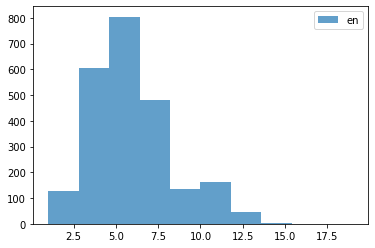

In [99]:
# 문장 길이 체크
import matplotlib.pyplot as plt

len_titles = []
for title in cleaned_titles:
    len_titles.append(len(title))

plt.hist(len_titles, label='en', alpha=0.7)
plt.legend()
plt.show()

In [94]:
ser = pd.Series(cleaned_titles)

In [96]:
ser.to_csv(r'./\cleaned_titles.csv')

### 영어 단어들을 숫자로 임베딩 해주자

### 적어도 2회 이상 등장한 단어들에 대해서만 고려할 것이다.

In [124]:
low_count = 0
high_count = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count >= 2:
        high_count += 1
print(high_count)

2155


In [125]:
tokenizer = Tokenizer(2155)
tokenizer.fit_on_texts(words_list)
data = tokenizer.texts_to_sequences(cleaned_titles)

In [127]:
print(data)

[[1266, 611, 1267, 168, 232, 17, 1268, 29, 467, 359], [612, 468, 92], [1269, 1270, 73, 613], [614, 1271, 233, 93], [13, 27, 130], [54, 615, 282], [1272, 1273, 1274, 847, 848, 616, 360, 66], [74, 151, 169, 1275], [1276, 4, 1277, 283, 469, 1278], [470, 849], [361, 617, 284, 850, 14], [111, 94, 75, 285, 1, 8], [234, 851, 1279], [190, 1280, 286, 47], [152, 284], [852, 853, 235, 1281, 236, 18, 6, 618, 82], [362, 1282, 8, 5, 471, 363], [849, 1283], [131, 1284, 1285, 20, 48, 1285, 131], [83, 1, 3, 15, 63], [472, 1286, 76, 84], [237, 22, 33], [238, 364, 1287], [1288, 619, 67, 35, 620, 9, 170, 23, 77], [854, 855, 621, 22, 100], [622, 623, 624, 473, 5, 474], [1289, 20, 48], [239, 132, 42], [191, 43, 1290, 856, 1, 44, 2], [1291, 1292, 857, 5, 131, 365, 93, 1293, 171, 133, 1, 8], [101, 625, 36, 1, 2], [102, 366, 134, 152], [626, 48, 1294], [627, 1295, 1296, 2], [3], [9, 1297, 20, 48, 1298, 628, 475, 287], [858, 133], [859, 85, 629, 860, 78], [86, 240, 861, 172, 86], [95, 630, 135, 1299, 862], [631

In [128]:
embedded_titles = pd.Series(data)
embedded_titles.to_csv(r'./\embeded_titles.csv')